In [ ]:
# clone the repo
!git clone --recursive https://github.com/ApurvaBhargava/pytorch-classification
# switch to repo's directory
import os
os.chdir('pytorch-classification')
os.getcwd()

Cloning into 'pytorch-classification'...
remote: Enumerating objects: 332, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 332 (delta 9), reused 36 (delta 6), pack-reused 287
Receiving objects: 100% (332/332), 88.37 MiB | 41.72 MiB/s, done.
Resolving deltas: 100% (176/176), done.
Submodule 'utils/progress' (https://github.com/verigak/progress.git) registered for path 'utils/progress'
Cloning into '/content/pytorch-classification/utils/progress'...
remote: Enumerating objects: 306, done.        
remote: Counting objects: 100% (42/42), done.        
remote: Compressing objects: 100% (31/31), done.        
remote: Total 306 (delta 19), reused 28 (delta 11), pack-reused 264        
Receiving objects: 100% (306/306), 662.72 KiB | 20.08 MiB/s, done.
Resolving deltas: 100% (176/176), done.
Submodule path 'utils/progress': checked out '715a2e130f14fa95c092c771813fb1c729dae333'


'/content/pytorch-classification'

In [ ]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import torch
import models.cifar as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as data
from torch.nn import Softmax
import cv2
from collections import defaultdict
import pandas as pd
from scipy.stats import entropy
from scipy.cluster.hierarchy import dendrogram, linkage

In [ ]:
# Load and transform the test data

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

dataloader = datasets.CIFAR100
num_classes = 100

testset = dataloader(root='./data', train=False, download=True, transform=transform_test)
testloader = data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Get class names
class_names = testset.classes


Extracting ./data/cifar-100-python.tar.gz to ./data


In [ ]:
output_list_dict = defaultdict(list)
target_list_dict = defaultdict(list)

checkpoint_list = ['checkpoint0.pth.tar', 'checkpoint9.pth.tar', 'checkpoint19.pth.tar', 'checkpoint29.pth.tar', 'checkpoint59.pth.tar', 
                 'checkpoint89.pth.tar', 'checkpoint119.pth.tar', 'model_best.pth.tar']

for chkpoint in checkpoint_list:
  # Get model blueprint and load from checkpoint
  model = models.__dict__['densenet'](
                      num_classes=100,
                      depth=100,
                      growthRate=12,
                      compressionRate=2,
                      dropRate=0,
                  )
  model = torch.nn.DataParallel(model).cuda()
  checkpoint = torch.load('/content/pytorch-classification/checkpoints/cifar100/densenet-bc-100-12/'+chkpoint)
  best_acc = checkpoint['best_acc']
  print('Validation accuracy: ' + str(best_acc.item()))
  model.load_state_dict(checkpoint['state_dict'])

  # Get targets and outputs
  output_list = []
  target_list = []
  softmax = Softmax(dim=1)
  model.eval()
  for batch_idx, (inputs, targets) in enumerate(testloader):
    inputs, targets = inputs.cuda(), targets.cuda()
    inputs, targets = torch.autograd.Variable(inputs, volatile=True), torch.autograd.Variable(targets)
    # compute output
    outputs = softmax(model(inputs)).detach().cpu().numpy()
    outputs = np.argmax(outputs, axis=1)
    output_list.extend(outputs)
    target_list.extend(targets.detach().cpu().numpy())
  print('Correct out of 10000: '+str((np.array(output_list)==np.array(target_list)).sum()))
  output_list_dict[chkpoint.split('.')[0]] = output_list
  target_list_dict[chkpoint.split('.')[0]] = target_list

Validation accuracy: 16.65999984741211


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Correct out of 10000: 1666
Validation accuracy: 56.32999801635742
Correct out of 10000: 5633
Validation accuracy: 61.05999755859375
Correct out of 10000: 5897
Validation accuracy: 62.12999725341797
Correct out of 10000: 6126
Validation accuracy: 65.41999816894531
Correct out of 10000: 6271
Validation accuracy: 67.08000183105469
Correct out of 10000: 6462
Validation accuracy: 67.08000183105469
Correct out of 10000: 6566
Validation accuracy: 77.0999984741211
Correct out of 10000: 7710


In [ ]:
# Print output for misclassified images for best model
output_list = output_list_dict['model_best']
target_list = target_list_dict['model_best']
for i in range(len(output_list)):
  if output_list[i]!=target_list[i]:
    pass
    #print("{} -> {}".format(class_names[output_list[i]], class_names[target_list[i]]))

In [ ]:
checkpoint_list = ['checkpoint0.pth.tar', 'checkpoint9.pth.tar', 'checkpoint29.pth.tar', 'checkpoint119.pth.tar', 'model_best.pth.tar']
aquatic, plants, animals, people, transport = defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list)

for chkpoint in checkpoint_list:

  output_list = output_list_dict[chkpoint.split('.')[0]]
  target_list = target_list_dict[chkpoint.split('.')[0]]

  # water organisms
  small_fish = [class_names.index(x) for x in ['aquarium_fish', 'trout', 'flatfish']]
  big_fish_mammal = [class_names.index(x) for x in ['dolphin', 'whale', 'shark', 'ray']]
  aquatic_mammal = [class_names.index(x) for x in ['beaver', 'seal', 'otter']]
  all_aquatic_life = small_fish + big_fish_mammal + aquatic_mammal

  class_wrong, class_general, class_med, class_specific = 0, 0, 0, 0
  for i in range(len(target_list)):
    if target_list[i] in all_aquatic_life:
      if target_list[i]==output_list[i]:
        class_specific +=1
      elif (target_list[i] in small_fish and output_list[i] in small_fish) or \
      (target_list[i] in big_fish_mammal and output_list[i] in big_fish_mammal) or \
      (target_list[i] in aquatic_mammal and output_list[i] in aquatic_mammal):
        class_med += 1
      elif output_list[i] in all_aquatic_life:
        class_general += 1
      else:
        class_wrong += 1
  aquatic[chkpoint] = [class_wrong, class_general, class_med, class_specific]

  # nonmoving living things
  flowers = [class_names.index(x) for x in ['orchid', 'poppy', 'rose', 'sunflower', 'tulip']]
  trees = [class_names.index(x+'_tree') for x in ['maple', 'oak', 'palm', 'pine', 'willow']]+[class_names.index('forest')]
  living_nonmoving = flowers + trees

  class_wrong, class_general, class_med, class_specific = 0, 0, 0, 0
  for i in range(len(target_list)):
    if target_list[i] in living_nonmoving:
      if target_list[i]==output_list[i]:
        class_specific +=1
      elif (target_list[i] in flowers and output_list[i] in flowers) or \
      (target_list[i] in trees and output_list[i] in trees):
        class_med += 1
      elif output_list[i] in living_nonmoving:
        class_general += 1
      else:
        class_wrong += 1
  plants[chkpoint] = [class_wrong, class_general, class_med, class_specific]

  # moving livin things
  large_carniomni = [class_names.index(x) for x in ['bear', 'leopard', 'lion', 'tiger', 'wolf', 'fox']]
  #large_herbiomni = [class_names.index(x) for x in ['camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo']]
  small_animals = [class_names.index(x) for x in ['porcupine', 'possum', 'raccoon', 'skunk', 'hamster', 'mouse', 'rabbit', 'shrew', 'squirrel']]
  reptiles = [class_names.index(x) for x in ['crocodile', 'dinosaur', 'lizard', 'snake', 'turtle']]
  insects = [class_names.index(x) for x in ['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach']]
  non_insect_invertebrates = [class_names.index(x) for x in ['crab', 'lobster', 'snail', 'spider', 'worm']]
  animals_all = large_carniomni+small_animals+reptiles
  creatures_all = insects+non_insect_invertebrates
  living_moving = animals_all+creatures_all

  class_wrong, class_general, class_med, class_subspecific, class_specific = 0, 0, 0, 0, 0
  for i in range(len(target_list)):
    if target_list[i] in living_moving:
      if target_list[i]==output_list[i]:
        class_specific +=1
      elif (target_list[i] in large_carniomni and output_list[i] in large_carniomni) or \
      (target_list[i] in small_animals and output_list[i] in small_animals) or \
      (target_list[i] in reptiles and output_list[i] in reptiles) or \
      (target_list[i] in insects and output_list[i] in insects) or \
      (target_list[i] in non_insect_invertebrates and output_list[i] in non_insect_invertebrates):
        class_subspecific += 1
      elif (target_list[i] in animals_all and output_list[i] in animals_all) or \
      (target_list[i] in creatures_all and output_list[i] in creatures_all):
        class_med += 1
      elif output_list[i] in living_moving:
        class_general += 1
      else:
        class_wrong += 1
  animals[chkpoint] = [class_wrong, class_general, class_med, class_subspecific, class_specific]

  # humans
  man_boy = [class_names.index(x) for x in ['man', 'woman']]
  woman_girl = [class_names.index(x) for x in ['boy', 'girl']]
  babies = [class_names.index(x) for x in ['baby']]
  humans = man_boy + woman_girl + babies

  class_wrong, class_general, class_med, class_specific = 0, 0, 0, 0
  for i in range(len(target_list)):
    if target_list[i] in humans:
      if target_list[i]==output_list[i]:
        class_specific +=1
      elif (target_list[i] in man_boy and output_list[i] in man_boy) or \
      (target_list[i] in woman_girl and output_list[i] in woman_girl) or \
      (target_list[i] in babies and output_list[i] in babies):
        class_med += 1
      elif output_list[i] in humans:
        class_general += 1
      else:
        class_wrong += 1
  people[chkpoint] = [class_wrong, class_general, class_med, class_specific]

  # vehicles
  two_wheel = [class_names.index(x) for x in ['bicycle', 'motorcycle']]
  four_wheel = [class_names.index(x) for x in ['bus', 'pickup_truck', 'lawn_mower', 'tractor']]
  multi_wheel = [class_names.index(x) for x in ['train', 'streetcar', 'tank']]
  vehicles = two_wheel + four_wheel + multi_wheel

  class_wrong, class_general, class_med, class_specific = 0, 0, 0, 0
  for i in range(len(target_list)):
    if target_list[i] in vehicles:
      if target_list[i]==output_list[i]:
        class_specific +=1
      elif (target_list[i] in two_wheel and output_list[i] in two_wheel) or \
      (target_list[i] in four_wheel and output_list[i] in four_wheel) or \
      (target_list[i] in multi_wheel and output_list[i] in multi_wheel):
        class_med += 1
      elif output_list[i] in vehicles:
        class_general += 1
      else:
        class_wrong += 1
  transport[chkpoint] = [class_wrong, class_general, class_med, class_specific]

In [ ]:
color_list = []
for color in sns.color_palette("Paired")[:4]:
  color_list.append(color)

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


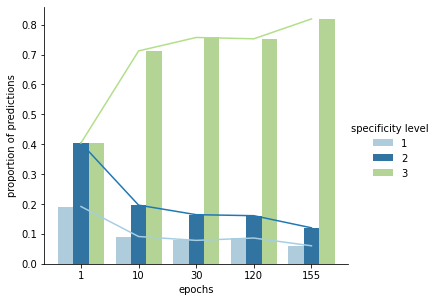

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


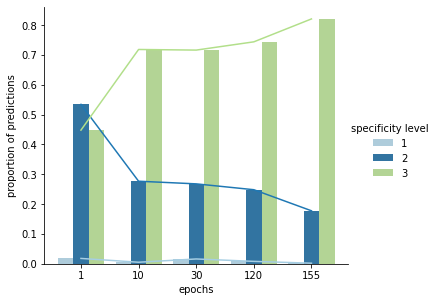

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


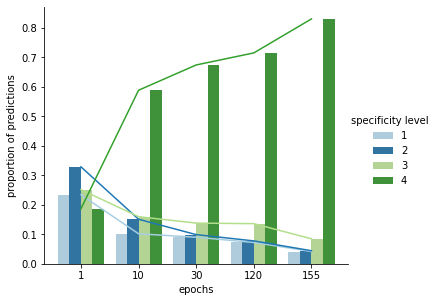

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


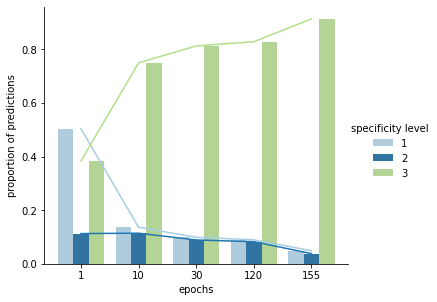

In [ ]:
epoch_list = [1, 10, 30, 120, 155]
sns.set_style(None)
xticks_val = ['epoch: '+str(x) for x in epoch_list]
for dictionary in [aquatic, plants, animals, transport]:
  temp = (pd.DataFrame.from_dict(dictionary).T).loc[:,1:]
  temp = temp.divide(np.sum(temp, axis=1), axis=0)
  temp['epochs'] = [str(x) for x in epoch_list]
  temp = pd.melt(temp, id_vars="epochs", var_name="specificity level", value_name="proportion of predictions")
  g=sns.factorplot(x='epochs', y='proportion of predictions', hue='specificity level', data=temp, kind='bar', palette=sns.color_palette("Paired"))
  mypalette = {1:color_list[0], 2:color_list[1], 3:color_list[2], 4:color_list[3]}
  g=sns.lineplot(x='epochs', y='proportion of predictions', hue='specificity level', data=temp, legend=None, palette=mypalette, markers='-o')
  plt.gcf().set_size_inches(6, 4)
  plt.show()

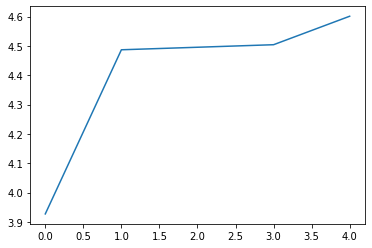

In [ ]:
# Entropy of response distribution
entropy_list = []
for chkpoint in checkpoint_list:
  output_list = output_list_dict[chkpoint.split('.')[0]]
  output_prob = pd.Series(output_list).value_counts(normalize=True).reindex(range(0,100), fill_value=0)
  entropy_list.append(entropy(output_prob))
plt.plot(entropy_list)
plt.show()

In [ ]:
# Typicality plot
# Cluster plot

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


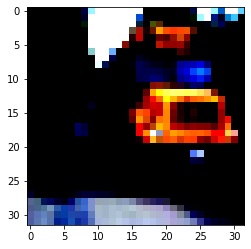

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


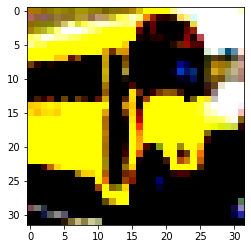

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


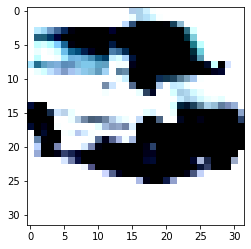

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


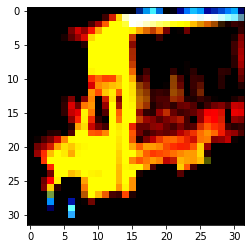

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


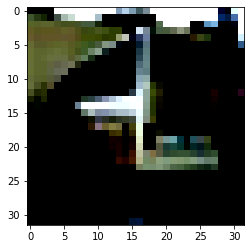

In [ ]:
# Visualize some images of a particular class
idx = class_names.index('bus')
max_count = 5
count = 0
for i in range(len(testset)):
  if testset[i][1]==idx:
    plt.imshow(testset[i][0].detach().cpu().numpy().transpose(1,2,0))
    plt.show()
    count+=1
    if count==max_count:
      break

In [ ]:
!ls /content/pytorch-classification/checkpoints/cifar100/densenet-bc-100-12/

checkpoint0.pth.tar    checkpoint239.pth.tar  checkpoint9.pth.tar
checkpoint119.pth.tar  checkpoint269.pth.tar  log.eps
checkpoint149.pth.tar  checkpoint299.pth.tar  log.txt
checkpoint179.pth.tar  checkpoint29.pth.tar   model_best.pth.tar
checkpoint19.pth.tar   checkpoint59.pth.tar
checkpoint209.pth.tar  checkpoint89.pth.tar


In [ ]:
all_checkpoints = ['checkpoint0.pth.tar', 'checkpoint9.pth.tar', 'checkpoint19.pth.tar', 'checkpoint29.pth.tar', 'checkpoint59.pth.tar', 
                   'checkpoint89.pth.tar', 'checkpoint119.pth.tar', 'checkpoint149.pth.tar', 'checkpoint179.pth.tar', 'checkpoint209.pth.tar', 
                   'checkpoint239.pth.tar', 'checkpoint269.pth.tar', 'checkpoint299.pth.tar']
for chkpoint in all_checkpoints:
  # Get model blueprint and load from checkpoint
  model = models.__dict__['densenet'](
                      num_classes=100,
                      depth=100,
                      growthRate=12,
                      compressionRate=2,
                      dropRate=0,
                  )
  model = torch.nn.DataParallel(model).cuda()
  checkpoint = torch.load('/content/pytorch-classification/checkpoints/cifar100/densenet-bc-100-12/'+chkpoint)
  best_acc = checkpoint['acc']
  print(chkpoint+': Validation accuracy: ' + str(best_acc.item()))
  model.load_state_dict(checkpoint['state_dict'])

checkpoint0.pth.tar: Validation accuracy: 16.65999984741211
checkpoint9.pth.tar: Validation accuracy: 56.32999801635742
checkpoint19.pth.tar: Validation accuracy: 58.96999740600586
checkpoint29.pth.tar: Validation accuracy: 61.2599983215332
checkpoint59.pth.tar: Validation accuracy: 62.709999084472656
checkpoint89.pth.tar: Validation accuracy: 64.6199951171875
checkpoint119.pth.tar: Validation accuracy: 65.65999603271484
checkpoint149.pth.tar: Validation accuracy: 65.0199966430664
checkpoint179.pth.tar: Validation accuracy: 76.50999450683594
checkpoint209.pth.tar: Validation accuracy: 76.0
checkpoint239.pth.tar: Validation accuracy: 75.38999938964844
checkpoint269.pth.tar: Validation accuracy: 73.8499984741211
checkpoint299.pth.tar: Validation accuracy: 74.37999725341797


In [ ]:
from sklearn.cluster import KMeans

fc_weights = model.module.fc.weight.data.detach().cpu().numpy()
kmeans = KMeans(n_clusters=15, random_state=0, tol=0.00001).fit(fc_weights)
kmeans_labels = kmeans.labels_
for i in range(15):
  #print(np.array(class_names)[np.where(kmeans_labels==i)[0]])
  #print()
  pass

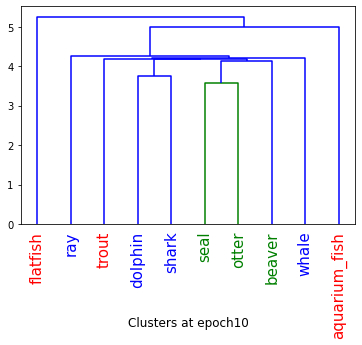

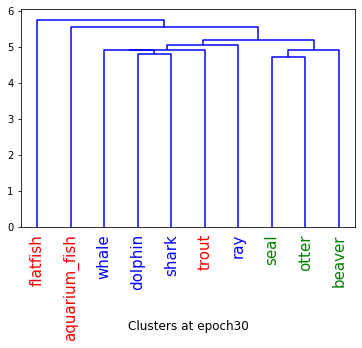

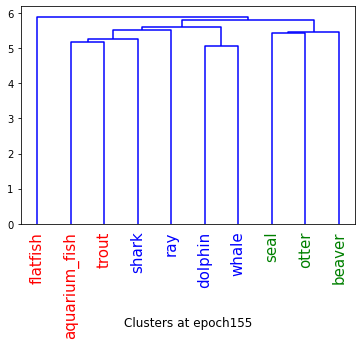

In [ ]:
all_checkpoints = ['checkpoint9.pth.tar','checkpoint29.pth.tar', 'model_best.pth.tar']
subplt = [131, 132, 133]
eps = [10,30,155]
for i in range(3):
  # Get model blueprint and load from checkpoint
  model = models.__dict__['densenet'](
                      num_classes=100,
                      depth=100,
                      growthRate=12,
                      compressionRate=2,
                      dropRate=0,
                  )
  model = torch.nn.DataParallel(model).cuda()
  checkpoint = torch.load('/content/pytorch-classification/checkpoints/cifar100/densenet-bc-100-12/'+all_checkpoints[i])
  best_acc = checkpoint['acc']
  #print(chkpoint+': Validation accuracy: ' + str(best_acc.item()))
  model.load_state_dict(checkpoint['state_dict'])
  fc_weights = model.module.fc.weight.data.detach().cpu().numpy()
  Z = linkage(fc_weights[all_aquatic_life], optimal_ordering=True)
  plt.figure(figsize=(6,4))
  dendrogram(Z, labels=np.array(class_names)[all_aquatic_life], leaf_font_size=15, leaf_rotation=90)
  label_colors = {}
  for lbl in ['aquarium_fish', 'trout', 'flatfish']: label_colors[lbl] = 'r'
  for lbl in ['dolphin', 'shark', 'whale', 'ray']: label_colors[lbl] = 'b'
  for lbl in ['beaver', 'seal', 'otter']: label_colors[lbl] = 'g'
  ax = plt.gca()
  xlbls = ax.get_xmajorticklabels()
  for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])
  plt.title('Clusters at epoch'+str(eps[i]), y=-0.5)
plt.show()

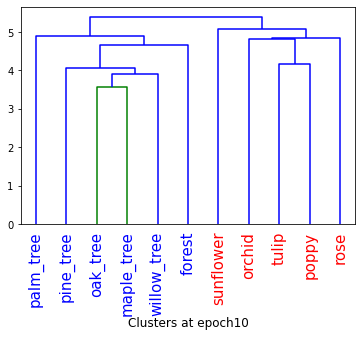

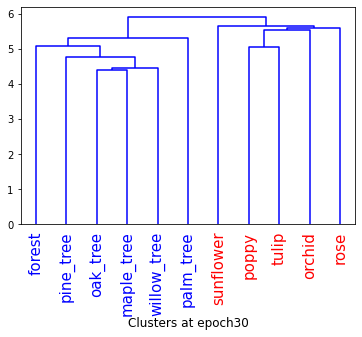

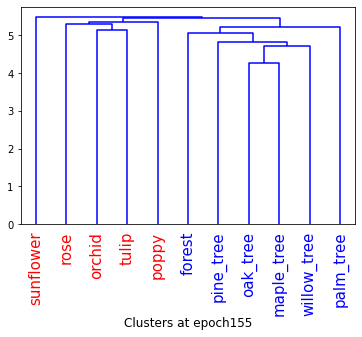

In [ ]:
all_checkpoints = ['checkpoint9.pth.tar','checkpoint29.pth.tar', 'model_best.pth.tar']
subplt = [131, 132, 133]
for i in range(3):
  # Get model blueprint and load from checkpoint
  model = models.__dict__['densenet'](
                      num_classes=100,
                      depth=100,
                      growthRate=12,
                      compressionRate=2,
                      dropRate=0,
                  )
  model = torch.nn.DataParallel(model).cuda()
  checkpoint = torch.load('/content/pytorch-classification/checkpoints/cifar100/densenet-bc-100-12/'+all_checkpoints[i])
  best_acc = checkpoint['acc']
  #print(chkpoint+': Validation accuracy: ' + str(best_acc.item()))
  model.load_state_dict(checkpoint['state_dict'])
  fc_weights = model.module.fc.weight.data.detach().cpu().numpy()
  Z = linkage(fc_weights[living_nonmoving], optimal_ordering=True)
  plt.figure(figsize=(6,4))
  dendrogram(Z, labels=np.array(class_names)[living_nonmoving], leaf_font_size=15, leaf_rotation=90)
  label_colors = {}
  for lbl in ['orchid', 'poppy', 'rose', 'sunflower', 'tulip']: label_colors[lbl] = 'r'
  for lbl in ['maple_tree', 'oak_tree', 'palm_tree', 'pine_tree', 'willow_tree',  'forest']: label_colors[lbl] = 'b'
  ax = plt.gca()
  xlbls = ax.get_xmajorticklabels()
  for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])
  plt.title('Clusters at epoch'+str(eps[i]), y=-0.5)
plt.show()

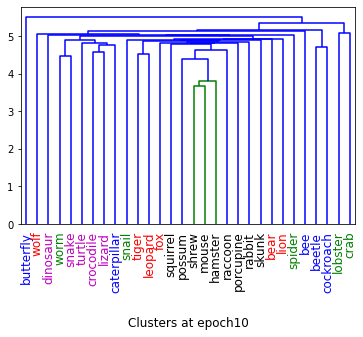

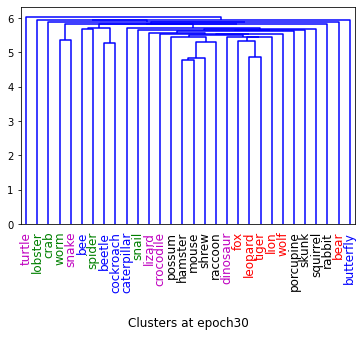

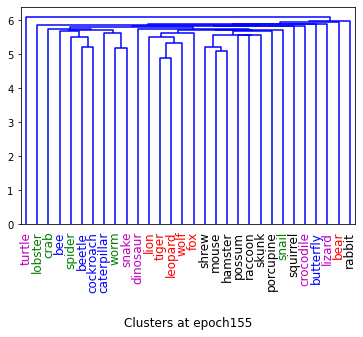

In [ ]:
all_checkpoints = ['checkpoint9.pth.tar','checkpoint29.pth.tar', 'model_best.pth.tar']
subplt = [131, 132, 133]
for i in range(3):
  # Get model blueprint and load from checkpoint
  model = models.__dict__['densenet'](
                      num_classes=100,
                      depth=100,
                      growthRate=12,
                      compressionRate=2,
                      dropRate=0,
                  )
  model = torch.nn.DataParallel(model).cuda()
  checkpoint = torch.load('/content/pytorch-classification/checkpoints/cifar100/densenet-bc-100-12/'+all_checkpoints[i])
  best_acc = checkpoint['acc']
  #print(chkpoint+': Validation accuracy: ' + str(best_acc.item()))
  model.load_state_dict(checkpoint['state_dict'])
  fc_weights = model.module.fc.weight.data.detach().cpu().numpy()
  Z = linkage(fc_weights[living_moving], optimal_ordering=True)
  plt.figure(figsize=(6,4))
  dendrogram(Z, labels=np.array(class_names)[living_moving], leaf_font_size=12, leaf_rotation=90) 
  label_colors = {}
  for lbl in ['bear', 'leopard', 'lion', 'tiger', 'wolf', 'fox']: label_colors[lbl] = 'r'
  for lbl in ['porcupine', 'possum', 'raccoon', 'skunk', 'hamster', 'mouse', 'rabbit', 'shrew', 'squirrel']: label_colors[lbl] = 'black'
  for lbl in ['crocodile', 'dinosaur', 'lizard', 'snake', 'turtle']: label_colors[lbl] = 'm'
  for lbl in ['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach']: label_colors[lbl] = 'b'
  for lbl in ['crab', 'lobster', 'snail', 'spider', 'worm']: label_colors[lbl] = 'g'
  ax = plt.gca()
  xlbls = ax.get_xmajorticklabels()
  for lbl in xlbls:
      lbl.set_color(label_colors[lbl.get_text()])
  plt.title('Clusters at epoch'+str(eps[i]), y=-0.5)
plt.show()

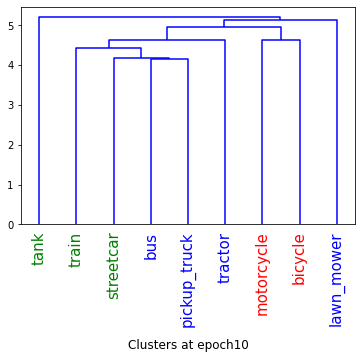

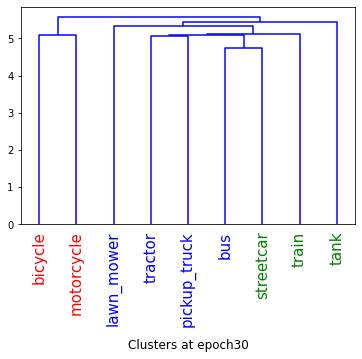

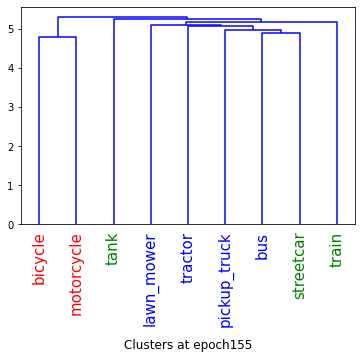

In [ ]:
all_checkpoints = ['checkpoint9.pth.tar','checkpoint29.pth.tar', 'model_best.pth.tar']
subplt = [131, 132, 133]
for i in range(3):
  # Get model blueprint and load from checkpoint
  model = models.__dict__['densenet'](
                      num_classes=100,
                      depth=100,
                      growthRate=12,
                      compressionRate=2,
                      dropRate=0,
                  )
  model = torch.nn.DataParallel(model).cuda()
  checkpoint = torch.load('/content/pytorch-classification/checkpoints/cifar100/densenet-bc-100-12/'+all_checkpoints[i])
  best_acc = checkpoint['acc']
  #print(chkpoint+': Validation accuracy: ' + str(best_acc.item()))
  model.load_state_dict(checkpoint['state_dict'])
  fc_weights = model.module.fc.weight.data.detach().cpu().numpy()
  Z = linkage(fc_weights[vehicles], optimal_ordering=True)
  plt.figure(figsize=(6,4))
  dendrogram(Z, labels=np.array(class_names)[vehicles], leaf_font_size=15, leaf_rotation=90)
  label_colors = {}
  for lbl in ['bicycle', 'motorcycle']: label_colors[lbl] = 'r'
  for lbl in ['bus', 'pickup_truck', 'lawn_mower', 'tractor']: label_colors[lbl] = 'b'
  for lbl in ['train', 'streetcar', 'tank']: label_colors[lbl] = 'g'
  ax = plt.gca()
  xlbls = ax.get_xmajorticklabels()
  for lbl in xlbls:
      lbl.set_color(label_colors[lbl.get_text()])
  plt.title('Clusters at epoch'+str(eps[i]), y=-0.6)
plt.show()

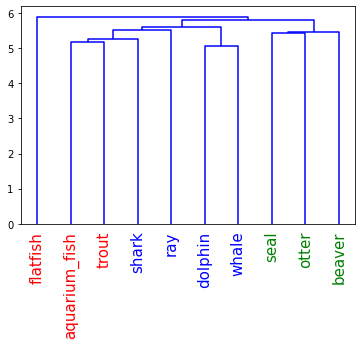

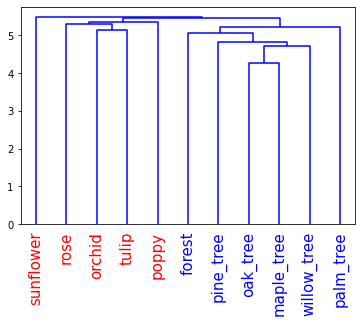

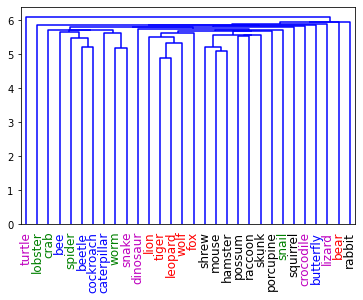

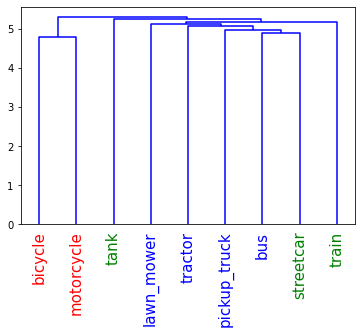

In [ ]:
output_list_dict = defaultdict(list)

checkpoint_list = ['checkpoint0.pth.tar', 'checkpoint19.pth.tar', 'checkpoint59.pth.tar', 'checkpoint119.pth.tar', 'model_best.pth.tar']

for chkpoint in checkpoint_list:
  # Get model blueprint and load from checkpoint
  model = models.__dict__['densenet'](
                      num_classes=100,
                      depth=100,
                      growthRate=12,
                      compressionRate=2,
                      dropRate=0,
                  )
  model = torch.nn.DataParallel(model).cuda()
  checkpoint = torch.load('/content/pytorch-classification/checkpoints/cifar100/densenet-bc-100-12/'+chkpoint)
  best_acc = checkpoint['best_acc']
  print('Validation accuracy: ' + str(best_acc.item()))
  model.load_state_dict(checkpoint['state_dict'])

  # Get targets and outputs
  output_list = []
  softmax = Softmax(dim=1)
  model.eval()
  for batch_idx, (inputs, targets) in enumerate(testloader):
    inputs, targets = inputs.cuda(), targets.cuda()
    inputs, targets = torch.autograd.Variable(inputs, volatile=True), torch.autograd.Variable(targets)
    # compute output
    outputs = softmax(model(inputs)).detach().cpu().numpy()
    output_list.extend(outputs)
  output_list_dict[chkpoint.split('.')[0]] = output_list

Validation accuracy: 16.65999984741211


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Validation accuracy: 61.05999755859375
Validation accuracy: 65.41999816894531
Validation accuracy: 67.08000183105469
Validation accuracy: 77.0999984741211


In [ ]:
# Category typicality
output_list = output_list_dict[chkpoint.split('.')[0]]
output_list = np.array(output_list)
for lst in [all_aquatic_life, small_fish, big_fish_mammal, aquatic_mammal, flowers, trees, small_animals, large_carniomni, creatures_all, four_wheel]:
  relevant_idx = []
  for i in range(len(target_list)):
    if target_list[i] in lst:
      relevant_idx.append(i)
  print(np.array(class_names)[np.argsort(output_list[relevant_idx].mean(axis=0))[::-1]][:2], np.sort(output_list[relevant_idx].mean(axis=0))[::-1][:2]*100)

['shark' 'dolphin'] [9.7514715 9.224448 ]
['aquarium_fish' 'trout'] [29.525814 28.763783]
['shark' 'whale'] [22.569635 21.824362]
['beaver' 'otter'] [25.565943 22.417366]
['orchid' 'sunflower'] [19.03994 18.98417]
['oak_tree' 'maple_tree'] [19.391533 16.27122 ]
['skunk' 'hamster'] [10.182622 10.061547]
['fox' 'leopard'] [16.101824 15.33345 ]
['cockroach' 'spider'] [9.913708 9.862237]
['lawn_mower' 'pickup_truck'] [22.95468 22.91802]


# FOR NOISE RESPONSE PART

In [ ]:
# Get model blueprint and load from checkpoint
model = models.__dict__['densenet'](
                    num_classes=100,
                    depth=100,
                    growthRate=12,
                    compressionRate=2,
                    dropRate=0,
                )
model = torch.nn.DataParallel(model).cuda()
checkpoint = torch.load('/content/pytorch-classification/checkpoints/cifar100/densenet-bc-100-12/model_best.pth.tar')
best_acc = checkpoint['best_acc']
print('Validation accuracy: ' + str(best_acc.item()))
model.load_state_dict(checkpoint['state_dict'])

# Get targets and outputs
output_list = []
output_prob_list = []
target_list = []
softmax = Softmax(dim=1)
model.eval()
for batch_idx, (inputs, targets) in enumerate(testloader):
  inputs, targets = inputs.cuda(), targets.cuda()
  inputs, targets = torch.autograd.Variable(inputs, volatile=True), torch.autograd.Variable(targets)
  # compute output
  outputs = softmax(model(inputs)).detach().cpu().numpy()
  output_prob_list.extend(outputs)
  outputs = np.argmax(outputs, axis=1)
  output_list.extend(outputs)
  target_list.extend(targets.detach().cpu().numpy())
print('Correct out of 10000: '+str((np.array(output_list)==np.array(target_list)).sum()))

In [ ]:
testset_humans = dataloader(root='./data', train=False, download=True, transform=None)
idx = 0
img = np.array(testset_humans[idx][0])
class_names = np.array(testset_humans.classes)
print('Actual class: '+class_names[testset_humans[idx][1]])
plt.imshow(img)
plt.show()
print('Top 5 predictions:')
print(class_names[np.argsort(output_prob_list[idx])[::-1]][:5])